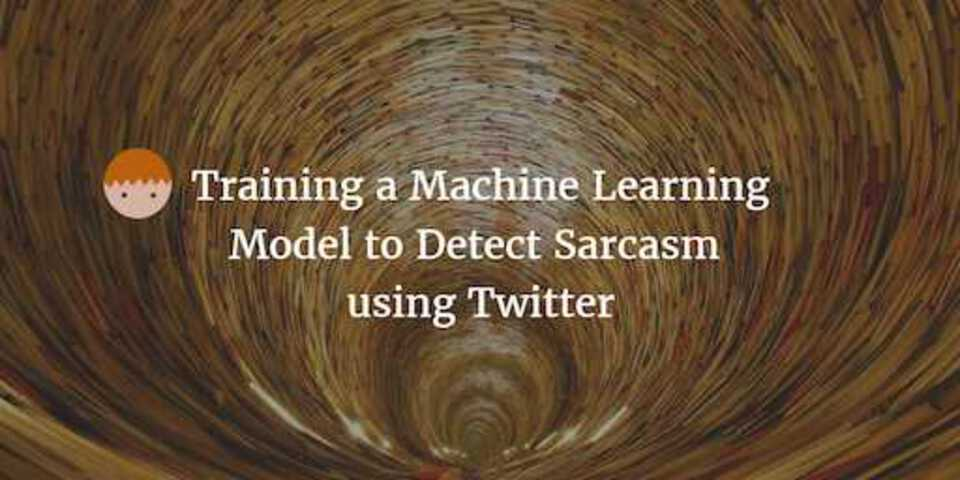

In [332]:
import pandas as pd, numpy as np, re, time
from nltk.stem.porter import PorterStemmer

In [333]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import emoji
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Flatten
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [334]:
data = pd.read_csv("train.En.csv")
data.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


# Extraire les labels et les données en question 

In [335]:
data["tweet"] = data["tweet"].replace('!','')
data["tweet"] = data["tweet"].replace('@','')
data["tweet"] = data["tweet"].replace('"','')
data["tweet"] = data["tweet"].replace('?','')
data["tweet"] = data["tweet"].replace('\"','')
data["tweet"] = data["tweet"].replace('\\_(ツ)_/','')

X= list(data["tweet"])
Y= np.array(list(data["sarcastic"]))

# Preprocessing

In [336]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
#Removing punctiation marks
def remove_punctuations(text):
    if(type(text) == str): 
        return re.sub('\[[^]]*\]', '', text)
    return text

#Removing special characters
def remove_specialchars(text):
    if(type(text)== str):
        return re.sub("[^a-zA-Z]"," ",text)
    return text

#Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    if(type(text) == str):
        final_text = []
        text = text.lower()
        text = nltk.word_tokenize(text)
    
        for word in text:
            if word not in set(stopwords.words('english')):
                lemma = nltk.WordNetLemmatizer()
                word = lemma.lemmatize(word) 
                final_text.append(word)
        return " ".join(final_text)
    return text


#Total function
def cleaning(text):
    if(type(text) == str): text = emoji.demojize(text)
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    text = remove_email(text)
    return text
def and_clean(li):
    li_temp = []
    for val in li:
        li_temp.append(cleaning(val))
    return li_temp

In [337]:
X = and_clean(X)

In [338]:
print(len(X),Y.shape)

3468 (3468,)


# TDIDF

In [339]:
# vectorizing the data with maximum of 5000 features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
def convert_to_tfidf(X,Y):
    tv = TfidfVectorizer(max_features = 5000)

    features = tv.fit_transform(X).toarray()
    selector = SelectKBest(chi2,k=350)# prend le test utilié dans le premier parametre et le nombre des variables qu'on veut les obtenir dans la deuxieme parametre
    features = selector.fit_transform(features,Y)#
    return features

In [340]:
features = convert_to_tfidf(X,Y)
print(features.shape,Y.shape)

(3468, 350) (3468,)


# word to vec

In [341]:
def getWords(X):
    words = []
    for i in X:
        l = []
        if(type(i) == str):
            for j in i.split():
                l.extend(i.split())
                break
            words.append(l) 
        else: words.append(l)
    return words

Xtr = getWords(X)

In [342]:
len(Xtr)

3468

In [344]:
import gensim
model_to_vec = gensim.models.Word2Vec(Xtr,
                 vector_size=100,
                 # Size is the length of our vector.
                )
model_to_vec.wv.vectors.shape

(1436, 100)

# Convert text to vector 

In [345]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, you can add the word to the list
            # or something different.
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()
                

In [346]:
sequencer = Sequencer(all_words = [token for seq in Xtr for token in seq],
              max_words = 1500,
              seq_len = 15,
              embedding_matrix = model_to_vec.wv.vectors
             )

In [347]:
np.array([token for seq in Xtr for token in seq])

array(['thing', 'got', 'college', ..., 'tartare', 'sauce',
       'montypythonesquedisses'], dtype='<U28')

In [348]:
# But before creating a PCA model using scikit-learn let's create
# vectors for our each vector
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in Xtr])
print(x_vecs.shape)
x_vecs = x_vecs**2

(3468, 1500)


In [349]:
np.isnan(x_vecs).sum()

0

# selection des variables

In [350]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)
pca_model.fit(x_vecs)

C:\Users\Ibrahim\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:595: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


PCA(n_components=50)

In [351]:
x_comps = pca_model.transform(x_vecs)
x_comps.shape
np.isnan(x_comps).sum()

0

In [352]:
# getting training and testing data
features = np.concatenate((features,x_comps),axis=1)
features_train, features_test, labels_train, labels_test = train_test_split(features,Y, test_size = .05, random_state = 0)

In [353]:
features.shape

(3468, 400)

In [354]:
# model 1:-
# Using linear support vector classifier
lsvc = LinearSVC()
# training the model
lsvc.fit(features_train, labels_train)
# getting the score of train and test data
print("SVM")
print(lsvc.score(features_train, labels_train)) # 90.93
print(lsvc.score(features_test, labels_test))   # 83.75
# model 2:-
# Using Gaussuan Naive Bayes
print("Naive Bayes")
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))  # 78.86
print(gnb.score(features_test, labels_test))    # 73.80
# model 3:-
# Logistic Regression
print("Logistic Regression")
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))   # 88.16
print(lr.score(features_test, labels_test))     # 83.08
# model 4:-
# Random Forest Classifier
print("Random Forest Classifier")
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))  # 98.82
print(rfc.score(features_test, labels_test))    # 79.71

SVM
0.8384942319368549
0.764367816091954
Naive Bayes
0.8491196114146934
0.7931034482758621
Logistic Regression
0.7568306010928961
0.735632183908046
Random Forest Classifier
0.9183363691560413
0.7586206896551724


accuracy: 0.7931034482758621
f1-score:  0.3571428571428571


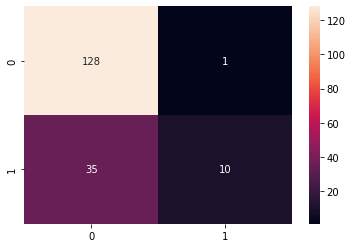

In [357]:
import seaborn as sns
y_pred = gnb.predict(features_test)
print("accuracy:",accuracy_score(labels_test,y_pred))
sns.heatmap(confusion_matrix(labels_test,y_pred),annot=True,fmt='d')
print("f1-score: ",f1_score(labels_test,y_pred))

# Ameliorer 

In [358]:
from sklearn.ensemble import VotingClassifier# technique simple de vote

model4 = VotingClassifier([
    ("svm",lsvc),
        ("naif",gnb),
        ("forest",rfc)
        ],voting='hard')
# voting = ("hard voting":vote sur les predictions ,"soft voting": vote sur les probabilités de chaque classe) 
for model in (lsvc,gnb,rfc,model4):
    model.fit(features_train,labels_train)
    print(model.__class__.__name__,model.score(features_test,labels_test))

LinearSVC 0.764367816091954
GaussianNB 0.7931034482758621
RandomForestClassifier 0.7586206896551724
VotingClassifier 0.7701149425287356


f1-score:  0.23076923076923078


<AxesSubplot:>

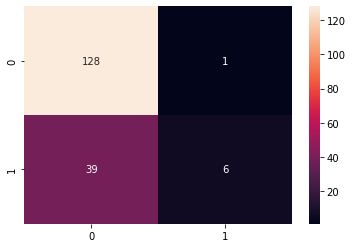

In [361]:
y_pred = model4.predict(features_test)
print("f1-score: ",f1_score(labels_test,y_pred))
sns.heatmap(confusion_matrix(labels_test,y_pred),annot=True,fmt='d')

In [362]:
# Stacking 
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
model = StackingClassifier([
        ("svm",lsvc),
        ("forest",gnb),
    ("model_jdid",rfc)
        ],final_estimator=SVC())# final_estimateur c'est l'estimateur qui va tester ceux qui ont raisont et ceux qui n'ont pas raison et predire la resultat final
model.fit(features_train,labels_train)
model.score(features_test,labels_test)
print("f1-score",f1_score(labels_test,model.predict(features_test)))

f1-score 0.3728813559322034


accuracy train:  0.8661202185792349


<AxesSubplot:>

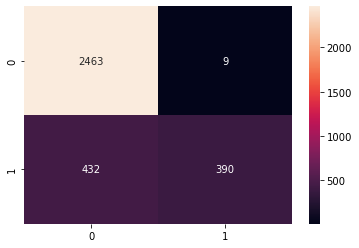

In [367]:
y_pred = model.predict(features_train)
print("accuracy train: ",accuracy_score(labels_train,y_pred))
sns.heatmap(confusion_matrix(labels_train,y_pred),annot=True,fmt='d')

In [368]:
f1_score(labels_train,y_pred)

0.6388206388206388

# Data set de test 

In [369]:
data_test = pd.read_csv("task_A_En_test.csv")
data_test.head()

,text,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0


In [370]:
data_test["text"] = data_test["text"].replace('!','')
data_test["text"] = data_test["text"].replace('@','')
data_test["text"] = data_test["text"].replace('"','')
data_test["text"] = data_test["text"].replace('?','')
data_test["text"] = data_test["text"].replace('\"','')
data_test["text"] = data_test["text"].replace('\\_(ツ)_/','')

X_test = list(data_test["text"])
Y_test= np.array(list(data_test["sarcastic"]))

In [371]:
X_test = and_clean(X_test)

In [372]:
features_test = convert_to_tfidf(X_test,Y_test)

In [373]:
x_vecs_test = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in X_test])
print(x_vecs.shape)
x_vecs_test = x_vecs_test**2

(3468, 1500)


In [374]:
x_comps_test = pca_model.transform(x_vecs_test)

In [375]:
features_test = np.concatenate((features_test,x_comps_test),axis=1)

In [376]:
x_comps_test.shape

(1400, 50)

Accuracy 0.9178571428571428


<AxesSubplot:>

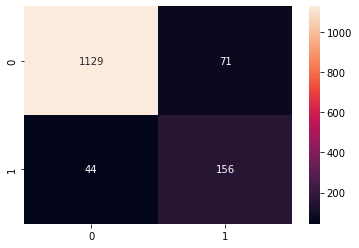

In [377]:
y_pred = lsvc.predict(features_test)
print("Accuracy",accuracy_score(Y_test,y_pred))
sns.heatmap(confusion_matrix(Y_test,y_pred),annot=True,fmt='d')

In [378]:
print("f1-score: ",f1_score(Y_test,y_pred))

f1-score:  0.7306791569086651


In [379]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1200
           1       0.69      0.78      0.73       200

    accuracy                           0.92      1400
   macro avg       0.82      0.86      0.84      1400
weighted avg       0.92      0.92      0.92      1400

